# Import Requirement

 Necessary libraries (transformers, sentence-transformers, and faiss-cpu) are installed in the environment. These libraries are crucial for building the recommendation system using transformers and FAISS for efficient similarity search.

In [1]:
!pip install transformers sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 30.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
import faiss

from transformers import pipeline

# Data Syntesis

This part creates synthetic datasets for students, courses, and enrollments. This is done to simulate a real-world scenario for demonstrating the recommendation system.

* **Student data**: A DataFrame is created with synthetic student information including `student_id`, `age`, `gender`, `education_level`, `learning_style`, and `preferred_topics`.
* **Course data**: A DataFrame is created with synthetic course information including `course_id`, `course_title`, `topic`, `difficulty`, `duration_hours`, `description`, and `prerequisites`.
* **Data for student enrollment on course including the progress**: A DataFrame is created simulating student enrollments in courses, including `enrollment_id`, `student_id`, `course_id`, `enrollment_date`, `completion_rate`, `time_spent_hours`, `status`, and `rating`. The `completion_rate` and `time_spent_hours` are adjusted based on the status to make the data more realistic.
* **Merge data** into a dataframe for easier reading: The three synthetic DataFrames are merged into a single DataFrame (`merged_df`) using `student_id` and `course_id`. This makes it easier to analyze and work with the combined data.
* **Save the dataframes to CSV files** in the data directory: The generated DataFrames are saved as CSV  files in a newly created 'data' directory. This allows for easy access to the synthetic data later.


In [3]:
# Student data
num_students = 100

student_data = {
    'student_id': [f'S{i:03d}' for i in range(1, num_students + 1)],
    'age': np.random.randint(18, 35, num_students),
    'gender': np.random.choice(['Male', 'Female', 'Other'], num_students, p=[0.45, 0.50, 0.05]),
    'education_level': np.random.choice(['High School', 'Undergraduate', 'Postgraduate'], num_students, p=[0.2, 0.6, 0.2]),
    'learning_style': np.random.choice(['Visual', 'Auditory', 'Kinesthetic', 'Reading/Writing'], num_students, p=[0.3, 0.2, 0.25, 0.25]),
    'preferred_topics': [
        ', '.join(np.random.choice(['Machine Learning', 'Data Science', 'Web Development', 'Mobile Development', 'Cybersecurity', 'Cloud Computing', 'UI/UX Design'], size=np.random.randint(1, 4), replace=False))
        for _ in range(num_students)
    ]
}

students_df = pd.DataFrame(student_data)
students_df

,student_id,age,gender,education_level,learning_style,preferred_topics
0,S001,29,Male,Postgraduate,Kinesthetic,Machine Learning
1,S002,27,Male,Undergraduate,Reading/Writing,"Data Science, Cybersecurity"
2,S003,24,Male,Undergraduate,Reading/Writing,Cloud Computing
3,S004,21,Female,Undergraduate,Visual,"Cybersecurity, Web Development, Data Science"
4,S005,28,Female,Undergraduate,Visual,UI/UX Design
...,...,...,...,...,...,...
95,S096,27,Male,Undergraduate,Visual,Data Science
96,S097,22,Male,Undergraduate,Visual,UI/UX Design
97,S098,34,Female,High School,Kinesthetic,"Cybersecurity, Web Development, Cloud Computing"
98,S099,32,Female,Postgraduate,Auditory,Machine Learning


In [4]:
# Course data
num_courses = 50

course_topics = ['Python', 'Data Science', 'Machine Learning', 'Deep Learning', 'Web Development', 'Mobile App Dev', 'Cloud Computing', 'Cybersecurity', 'UI/UX Design', 'Database Management', 'DevOps']
difficulty_levels = ['Beginner', 'Intermediate', 'Advanced']

course_data = {
    'course_id': [f'C{i:03d}' for i in range(1, num_courses + 1)],
    'course_title': [f'{np.random.choice(course_topics)} Fundamentals' if np.random.rand() < 0.5 else f'Advanced {np.random.choice(course_topics)}' for i in range(1, num_courses + 1)],
    'topic': [np.random.choice(course_topics) for _ in range(num_courses)],
    'difficulty': np.random.choice(difficulty_levels, num_courses, p=[0.4, 0.4, 0.2]),
    'duration_hours': np.random.randint(5, 50, num_courses),
    'description': [
        f"This course covers {np.random.choice(course_topics, size=2, replace=False)[0]} and {np.random.choice(course_topics, size=2, replace=False)[1]}. It's designed for {np.random.choice(difficulty_levels).lower()} learners and will help you master various aspects of {np.random.choice(course_topics).lower()}."
        for _ in range(num_courses)
    ],
    'prerequisites': [
        ', '.join(np.random.choice(course_topics, size=np.random.randint(0, 2), replace=False)) if np.random.rand() < 0.3 else ''
        for _ in range(num_courses)
    ]
}

courses_df = pd.DataFrame(course_data)
courses_df

,course_id,course_title,topic,difficulty,duration_hours,description,prerequisites
0,C001,Advanced Web Development,Data Science,Intermediate,13,This course covers Mobile App Dev and Web Deve...,
1,C002,Mobile App Dev Fundamentals,Web Development,Intermediate,45,This course covers Cybersecurity and UI/UX Des...,
2,C003,Cybersecurity Fundamentals,Cloud Computing,Beginner,18,This course covers Database Management and UI/...,
3,C004,Advanced DevOps,Cloud Computing,Intermediate,31,This course covers Machine Learning and Machin...,
4,C005,Python Fundamentals,DevOps,Advanced,38,This course covers Python and Python. It's des...,
5,C006,Advanced Cybersecurity,Web Development,Beginner,40,This course covers Database Management and Dev...,
6,C007,Cloud Computing Fundamentals,Python,Beginner,17,This course covers Database Management and Pyt...,
7,C008,Advanced Web Development,Machine Learning,Beginner,21,This course covers Python and Data Science. It...,
8,C009,Deep Learning Fundamentals,Database Management,Beginner,47,This course covers Python and Deep Learning. I...,
9,C010,Mobile App Dev Fundamentals,Mobile App Dev,Advanced,44,This course covers DevOps and Database Managem...,


In [5]:
# Data for student enrollment on course including the progress
num_enrollments = 500

enrollment_data = {
    'enrollment_id': [f'E{i:04d}' for i in range(1, num_enrollments + 1)],
    'student_id': np.random.choice(students_df['student_id'], num_enrollments),
    'course_id': np.random.choice(courses_df['course_id'], num_enrollments),
    'enrollment_date': pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 365, num_enrollments), unit='D'),
    'completion_rate': np.random.rand(num_enrollments).round(2), # 0.00 to 1.00
    'time_spent_hours': np.random.randint(1, 60, num_enrollments), # 1 to 59 hours
    'status': np.random.choice(['Completed', 'In Progress', 'Dropped'], num_enrollments, p=[0.6, 0.3, 0.1]),
    'rating': np.random.randint(1, 6, num_enrollments) # 1 to 5 stars
}

enrollments_df = pd.DataFrame(enrollment_data)

# Adjust completion_rate and time_spent_hours based on status
# Completed when completion_rate >= 0.8
enrollments_df.loc[enrollments_df['status'] == 'Completed', 'completion_rate'] = np.random.uniform(0.8, 1.0, (enrollments_df['status'] == 'Completed').sum()).round(2)
# Dropped when completion_rate  <= 0.3
enrollments_df.loc[enrollments_df['status'] == 'Dropped', 'completion_rate'] = np.random.uniform(0.0, 0.3, (enrollments_df['status'] == 'Dropped').sum()).round(2)

enrollments_df

,enrollment_id,student_id,course_id,enrollment_date,completion_rate,time_spent_hours,status,rating
0,E0001,S050,C042,2023-01-30,0.82,1,Completed,5
1,E0002,S041,C040,2023-04-18,0.89,46,Completed,4
2,E0003,S027,C007,2023-03-21,0.93,57,Completed,4
3,E0004,S036,C024,2023-11-10,0.87,43,Completed,5
4,E0005,S069,C014,2023-06-19,0.97,13,Completed,5
...,...,...,...,...,...,...,...,...
495,E0496,S008,C032,2023-07-30,0.96,42,Completed,3
496,E0497,S020,C042,2023-06-20,0.89,52,Completed,2
497,E0498,S075,C005,2023-08-11,0.87,23,Completed,4
498,E0499,S017,C050,2023-09-04,0.92,14,In Progress,1


In [6]:
# Merge data into a dataframe for easier reading
merged_df = pd.merge(enrollments_df, students_df, on='student_id', how='left')
merged_df = pd.merge(merged_df, courses_df, on='course_id', how='left')
merged_df.head()

,enrollment_id,student_id,course_id,enrollment_date,completion_rate,time_spent_hours,status,rating,age,gender,education_level,learning_style,preferred_topics,course_title,topic,difficulty,duration_hours,description,prerequisites
0,E0001,S050,C042,2023-01-30,0.82,1,Completed,5,30,Male,High School,Auditory,"Web Development, UI/UX Design, Mobile Development",Advanced Cybersecurity,Mobile App Dev,Beginner,46,This course covers Python and Mobile App Dev. ...,
1,E0002,S041,C040,2023-04-18,0.89,46,Completed,4,26,Other,Postgraduate,Reading/Writing,Web Development,Advanced Machine Learning,Machine Learning,Beginner,45,This course covers Database Management and Web...,
2,E0003,S027,C007,2023-03-21,0.93,57,Completed,4,20,Male,Undergraduate,Reading/Writing,"Mobile Development, Machine Learning, UI/UX De...",Cloud Computing Fundamentals,Python,Beginner,17,This course covers Database Management and Pyt...,
3,E0004,S036,C024,2023-11-10,0.87,43,Completed,5,33,Female,Postgraduate,Kinesthetic,Data Science,Advanced Mobile App Dev,Python,Beginner,24,This course covers Data Science and Database M...,
4,E0005,S069,C014,2023-06-19,0.97,13,Completed,5,19,Female,Undergraduate,Kinesthetic,Cloud Computing,Advanced Data Science,Machine Learning,Beginner,23,This course covers Data Science and Python. It...,


In [7]:
import os

# Create the data directory if it doesn't exist
if not os.path.exists('data'):
  os.makedirs('data')

# Save the dataframes to CSV files in the data directory
students_df.to_csv('data/students.csv', index=False)
courses_df.to_csv('data/courses.csv', index=False)
enrollments_df.to_csv('data/enrollments.csv', index=False)
merged_df.to_csv('data/merged_data.csv', index=False)

print("Dataframes saved to the 'data' directory.")

Dataframes saved to the 'data' directory.


# Data Exploration

This section performs basic exploratory data analysis (EDA) on the synthetic dataframes to understand their structure and content.

## Student Data

Displays information about the `students_df` DataFrame, including the data types and non-null counts of each column.

In [8]:
students_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   student_id        100 non-null    object
 1   age               100 non-null    int64 
 2   gender            100 non-null    object
 3   education_level   100 non-null    object
 4   learning_style    100 non-null    object
 5   preferred_topics  100 non-null    object
dtypes: int64(1), object(5)
memory usage: 4.8+ KB


see descriptive statistics of the students_df DataFrame, including counts, unique values, top values, frequencies for object types, and statistical measures like mean, std, min, max, and quartiles for numerical types.

In [9]:
students_df.describe(include='all')

,student_id,age,gender,education_level,learning_style,preferred_topics
count,100,100.000000,100,100,100,100
unique,100,NaN,3,3,4,53
top,S001,NaN,Male,Undergraduate,Visual,Cybersecurity
freq,1,NaN,57,62,30,9
mean,NaN,25.500000,NaN,NaN,NaN,NaN
std,NaN,5.084141,NaN,NaN,NaN,NaN
min,NaN,18.000000,NaN,NaN,NaN,NaN
25%,NaN,21.750000,NaN,NaN,NaN,NaN
50%,NaN,25.000000,NaN,NaN,NaN,NaN
75%,NaN,29.250000,NaN,NaN,NaN,NaN


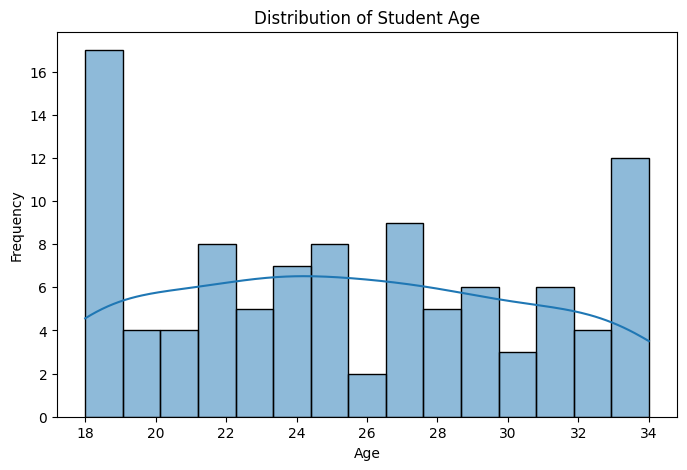

In [10]:
# Distribution of Age
plt.figure(figsize=(8, 5))
sns.histplot(students_df['age'], bins=15, kde=True)
plt.title('Distribution of Student Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

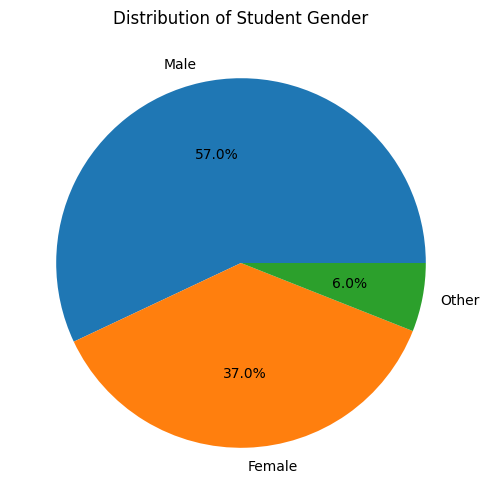

In [11]:
# Distribution of Gender
plt.figure(figsize=(6, 6))
students_df['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Student Gender')
plt.ylabel('')
plt.show()

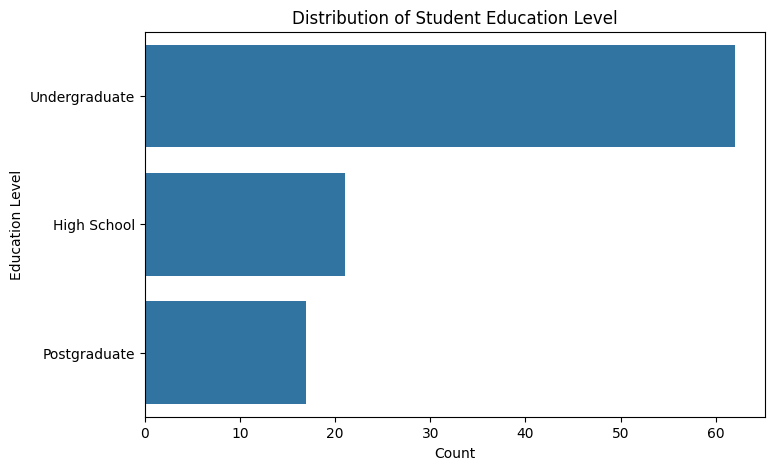

In [12]:
# Distribution of Education Level
plt.figure(figsize=(8, 5))
sns.countplot(data=students_df, y='education_level', order=students_df['education_level'].value_counts().index)
plt.title('Distribution of Student Education Level')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.show()

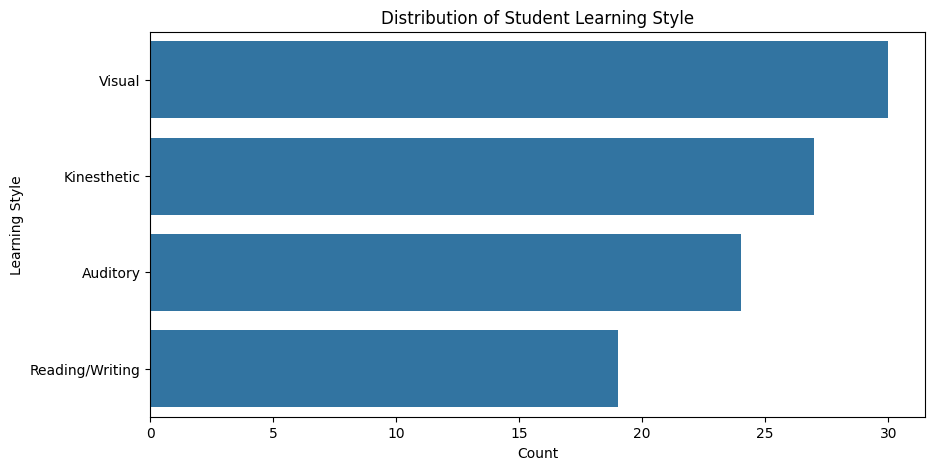

In [13]:
# Distribution of Learning Style
plt.figure(figsize=(10, 5))
sns.countplot(data=students_df, y='learning_style', order=students_df['learning_style'].value_counts().index)
plt.title('Distribution of Student Learning Style')
plt.xlabel('Count')
plt.ylabel('Learning Style')
plt.show()

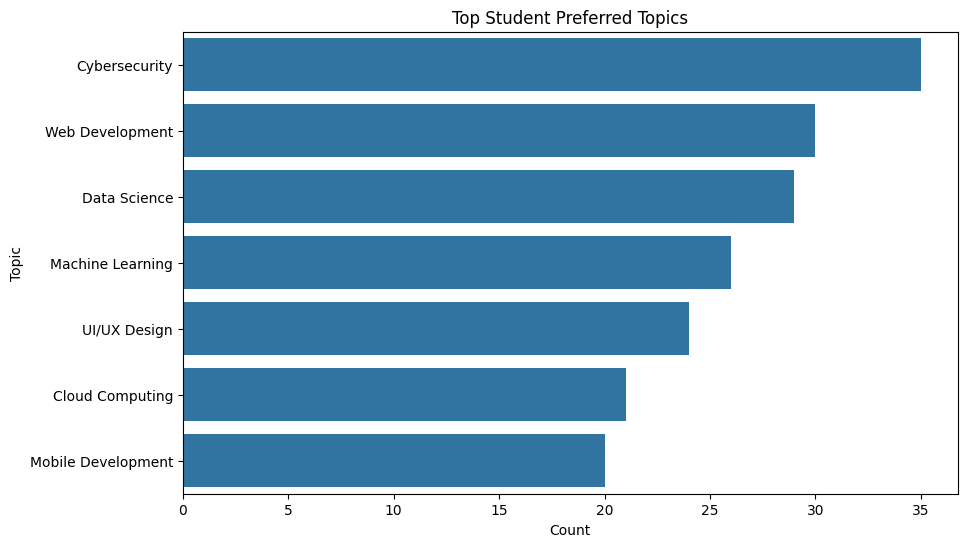

In [14]:
# Top Student Preferred Topics (extracting topics from comma-separated strings)
preferred_topics_list = students_df['preferred_topics'].str.split(', ').explode()
plt.figure(figsize=(10, 6))
sns.countplot(data=preferred_topics_list.to_frame(name='topic'), y='topic', order=preferred_topics_list.value_counts().index)
plt.title('Top Student Preferred Topics')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.show()

## Course Data

to know about dataframe information and column type

In [15]:
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   course_id       50 non-null     object
 1   course_title    50 non-null     object
 2   topic           50 non-null     object
 3   difficulty      50 non-null     object
 4   duration_hours  50 non-null     int64 
 5   description     50 non-null     object
 6   prerequisites   50 non-null     object
dtypes: int64(1), object(6)
memory usage: 2.9+ KB


In [16]:
courses_df.describe(include='all')

,course_id,course_title,topic,difficulty,duration_hours,description,prerequisites
count,50,50,50,50,50.000000,50,50
unique,50,20,11,3,NaN,50,6
top,C001,Advanced Web Development,Database Management,Beginner,NaN,This course covers Mobile App Dev and Web Deve...,
freq,1,5,8,22,NaN,1,43
mean,NaN,NaN,NaN,NaN,25.800000,NaN,NaN
std,NaN,NaN,NaN,NaN,13.032142,NaN,NaN
min,NaN,NaN,NaN,NaN,5.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,15.250000,NaN,NaN
50%,NaN,NaN,NaN,NaN,24.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,38.750000,NaN,NaN


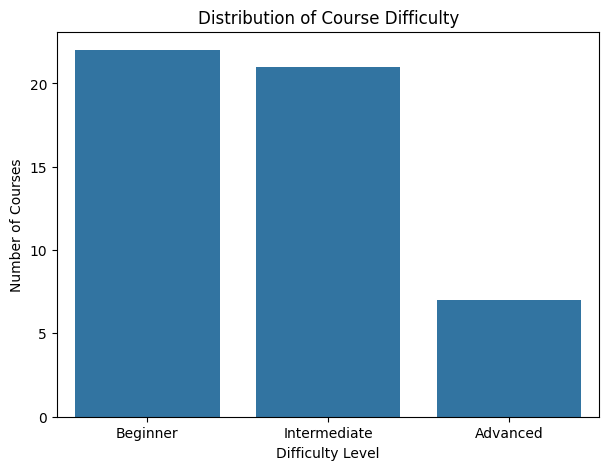

In [17]:
# Distribution of Course Difficulty
plt.figure(figsize=(7, 5))
sns.countplot(data=courses_df, x='difficulty', order=difficulty_levels)
plt.title('Distribution of Course Difficulty')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Courses')
plt.show()

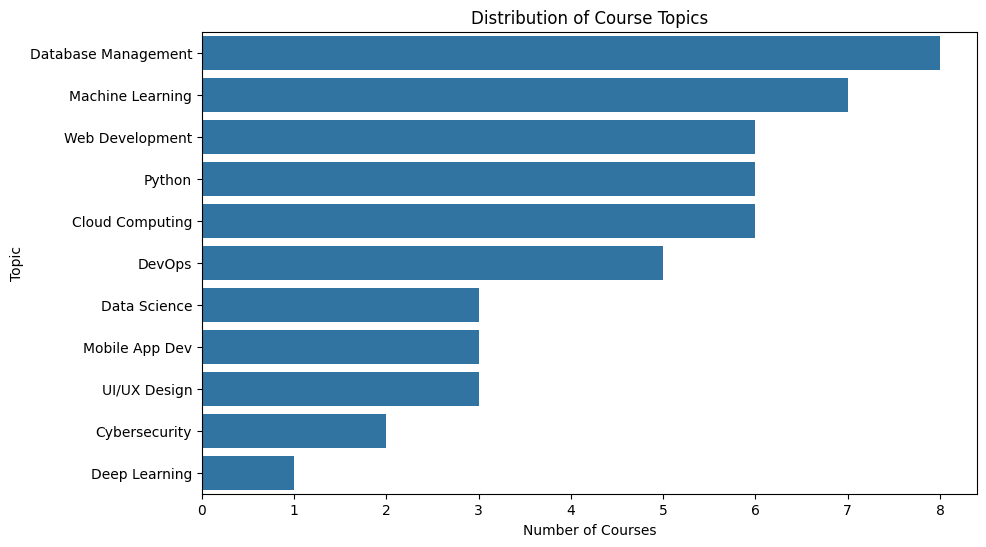

In [18]:
# Distribution of Course Topics
plt.figure(figsize=(10, 6))
sns.countplot(data=courses_df, y='topic', order=courses_df['topic'].value_counts().index)
plt.title('Distribution of Course Topics')
plt.xlabel('Number of Courses')
plt.ylabel('Topic')
plt.show()

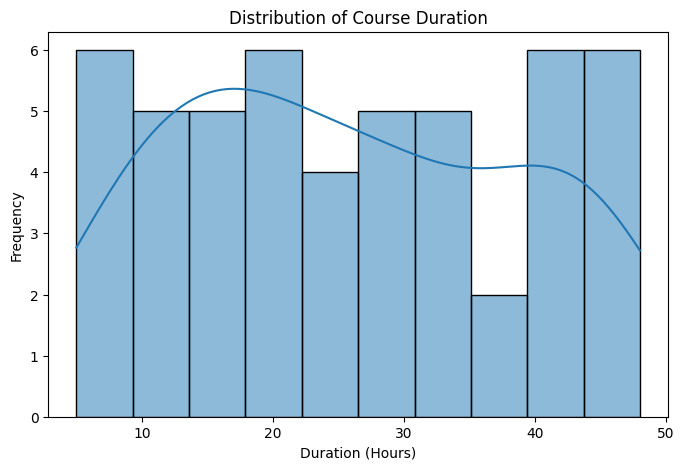

In [19]:
# Distribution of Course Duration
plt.figure(figsize=(8, 5))
sns.histplot(courses_df['duration_hours'], bins=10, kde=True)
plt.title('Distribution of Course Duration')
plt.xlabel('Duration (Hours)')
plt.ylabel('Frequency')
plt.show()

Lets see course characteristic. First i look for the colleration between the difficulty and duration. Normally, more difficult is more longer.

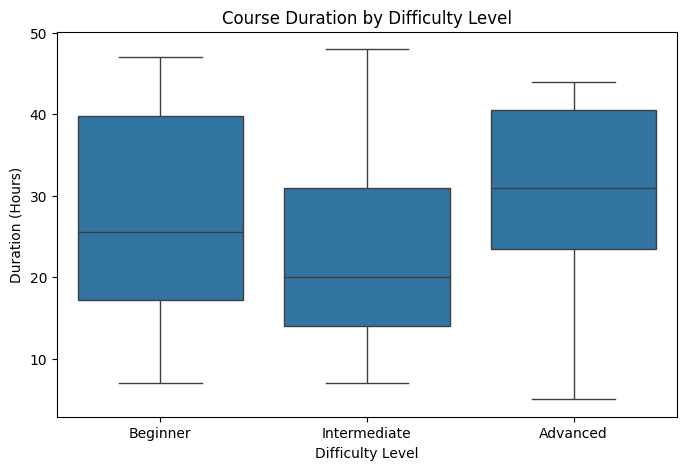

In [20]:
# Relationship between Difficulty and Duration
plt.figure(figsize=(8, 5))
sns.boxplot(data=courses_df, x='difficulty', y='duration_hours', order=difficulty_levels)
plt.title('Course Duration by Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Duration (Hours)')
plt.show()

## Enrollment Data

In [21]:
enrollments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   enrollment_id     500 non-null    object        
 1   student_id        500 non-null    object        
 2   course_id         500 non-null    object        
 3   enrollment_date   500 non-null    datetime64[ns]
 4   completion_rate   500 non-null    float64       
 5   time_spent_hours  500 non-null    int64         
 6   status            500 non-null    object        
 7   rating            500 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 31.4+ KB


In [22]:
enrollments_df.describe(include='all')

,enrollment_id,student_id,course_id,enrollment_date,completion_rate,time_spent_hours,status,rating
count,500,500,500,500,500.000000,500.000000,500,500.000000
unique,500,98,50,NaN,NaN,NaN,3,NaN
top,E0500,S069,C005,NaN,NaN,NaN,Completed,NaN
freq,1,10,19,NaN,NaN,NaN,318,NaN
mean,NaN,NaN,NaN,2023-07-07 00:05:45.600000,0.720320,30.260000,NaN,3.006000
min,NaN,NaN,NaN,2023-01-01 00:00:00,0.000000,1.000000,NaN,1.000000
25%,NaN,NaN,NaN,2023-04-07 18:00:00,0.610000,15.000000,NaN,2.000000
50%,NaN,NaN,NaN,2023-07-10 12:00:00,0.850000,31.500000,NaN,3.000000
75%,NaN,NaN,NaN,2023-10-06 06:00:00,0.930000,44.000000,NaN,4.000000
max,NaN,NaN,NaN,2023-12-31 00:00:00,1.000000,59.000000,NaN,5.000000


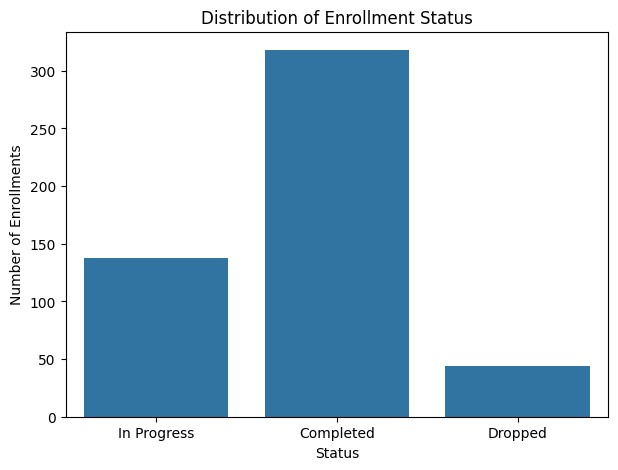

In [23]:
# Distribution of Enrollment Status
plt.figure(figsize=(7, 5))
sns.countplot(data=enrollments_df, x='status', order=['In Progress', 'Completed', 'Dropped'])
plt.title('Distribution of Enrollment Status')
plt.xlabel('Status')
plt.ylabel('Number of Enrollments')
plt.show()

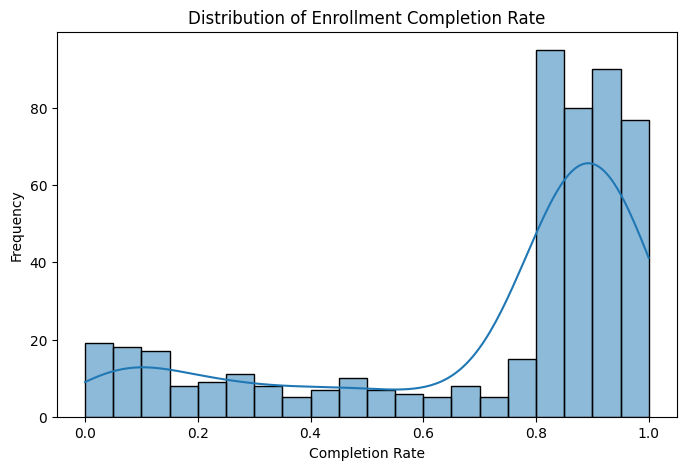

In [24]:
# Distribution of Completion Rate
plt.figure(figsize=(8, 5))
sns.histplot(enrollments_df['completion_rate'], bins=20, kde=True)
plt.title('Distribution of Enrollment Completion Rate')
plt.xlabel('Completion Rate')
plt.ylabel('Frequency')
plt.show()

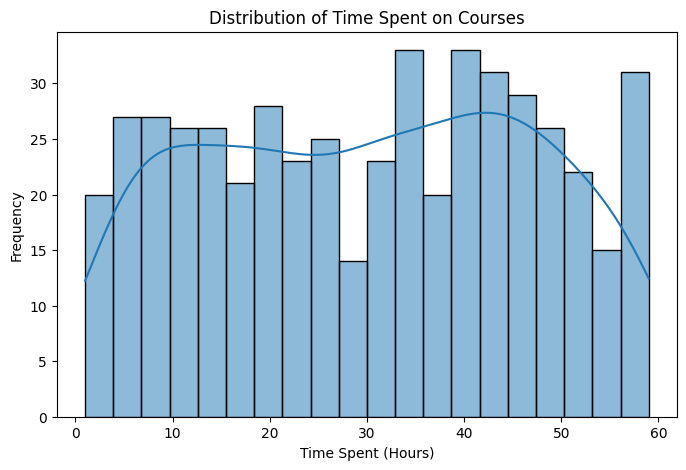

In [25]:
# Distribution of Time Spent in Hours
plt.figure(figsize=(8, 5))
sns.histplot(enrollments_df['time_spent_hours'], bins=20, kde=True)
plt.title('Distribution of Time Spent on Courses')
plt.xlabel('Time Spent (Hours)')
plt.ylabel('Frequency')
plt.show()

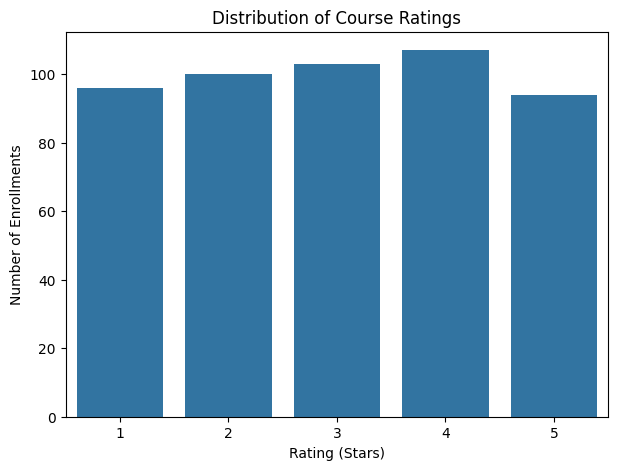

In [26]:
# Distribution of Course Ratings
plt.figure(figsize=(7, 5))
sns.countplot(data=enrollments_df, x='rating', order=sorted(enrollments_df['rating'].unique()))
plt.title('Distribution of Course Ratings')
plt.xlabel('Rating (Stars)')
plt.ylabel('Number of Enrollments')
plt.show()

Now we look for the enrollment patterns between the student.

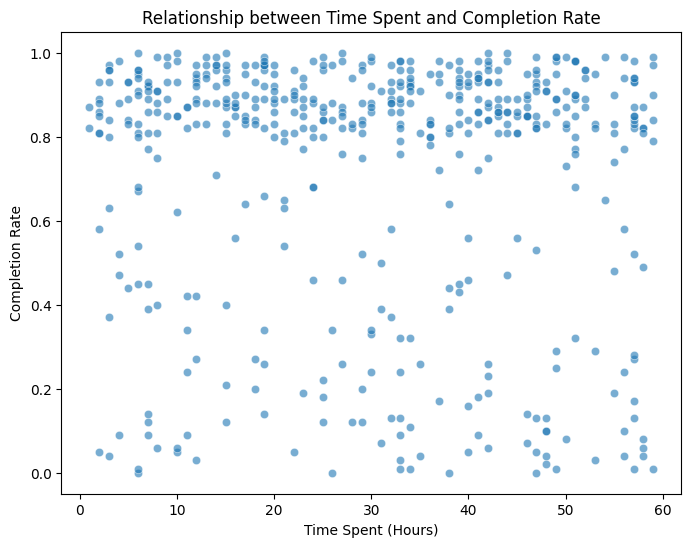

In [27]:
# Relationship between Completion Rate and Time Spent
plt.figure(figsize=(8, 6))
sns.scatterplot(data=enrollments_df, x='time_spent_hours', y='completion_rate', alpha=0.6)
plt.title('Relationship between Time Spent and Completion Rate')
plt.xlabel('Time Spent (Hours)')
plt.ylabel('Completion Rate')
plt.show()

The plot showing that there's no colleration between time spent and completion rate

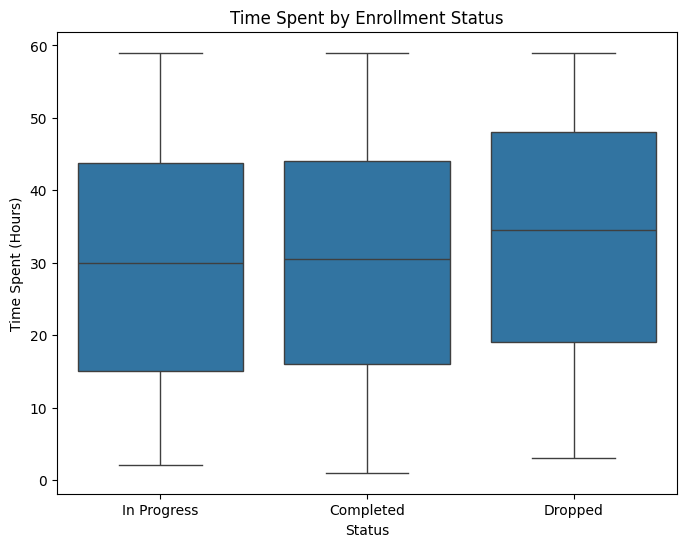

In [28]:
# Relationship between Status and Time Spent
plt.figure(figsize=(8, 6))
sns.boxplot(data=enrollments_df, x='status', y='time_spent_hours', order=['In Progress', 'Completed', 'Dropped'])
plt.title('Time Spent by Enrollment Status')
plt.xlabel('Status')
plt.ylabel('Time Spent (Hours)')
plt.show()

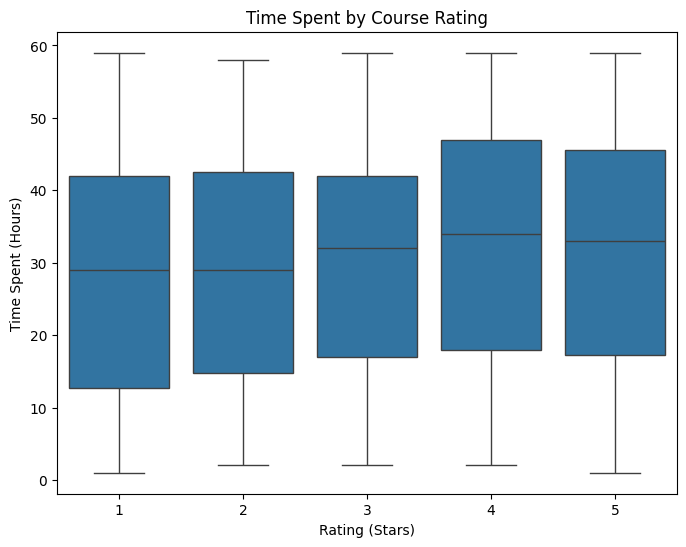

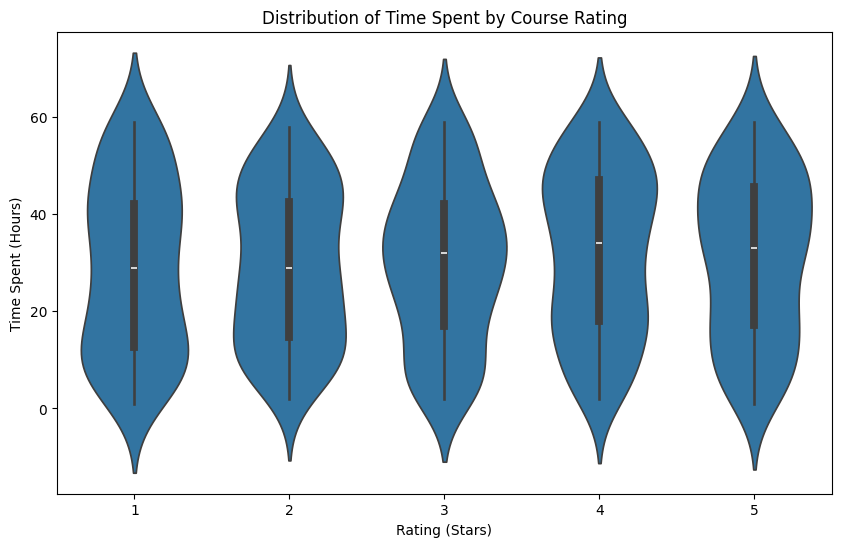


Average Time Spent per Course Rating:


,rating,time_spent_hours
0,1,28.895833
1,2,29.240000
2,3,29.854369
3,4,32.074766
4,5,31.117021


In [29]:
# Relationship between Rating and Time Spent
plt.figure(figsize=(8, 6))
sns.boxplot(data=enrollments_df, x='rating', y='time_spent_hours', order=sorted(enrollments_df['rating'].unique()))
plt.title('Time Spent by Course Rating')
plt.xlabel('Rating (Stars)')
plt.ylabel('Time Spent (Hours)')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=enrollments_df, x='rating', y='time_spent_hours', order=sorted(enrollments_df['rating'].unique()))
plt.title('Distribution of Time Spent by Course Rating')
plt.xlabel('Rating (Stars)')
plt.ylabel('Time Spent (Hours)')
plt.show()

# Calculate the average time spent for each rating
average_time_per_rating = enrollments_df.groupby('rating')['time_spent_hours'].mean().reset_index()
print("\nAverage Time Spent per Course Rating:")
average_time_per_rating

## Merged Data

In [30]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   enrollment_id     500 non-null    object        
 1   student_id        500 non-null    object        
 2   course_id         500 non-null    object        
 3   enrollment_date   500 non-null    datetime64[ns]
 4   completion_rate   500 non-null    float64       
 5   time_spent_hours  500 non-null    int64         
 6   status            500 non-null    object        
 7   rating            500 non-null    int64         
 8   age               500 non-null    int64         
 9   gender            500 non-null    object        
 10  education_level   500 non-null    object        
 11  learning_style    500 non-null    object        
 12  preferred_topics  500 non-null    object        
 13  course_title      500 non-null    object        
 14  topic             500 non-

In [31]:
# Check missing value
merged_df.isnull().sum()

,0
enrollment_id,0
student_id,0
course_id,0
enrollment_date,0
completion_rate,0
time_spent_hours,0
status,0
rating,0
age,0
gender,0


In [32]:
# Check duplicated data
merged_df.duplicated().sum()

np.int64(0)

# Feature Engineering

This section prepares the data for the recommendation engine by creating features for the LLM input and encoding categorical variables for the Collaborative Filtering Model.

## LLM Input

For LLM input, we need to build context-full text to represent the data.

* student profile text: A new column student_profile_text is created in the students_df DataFrame by combining relevant student attributes into a single text string. This text will be used as input for the LLM.
* comprehensive course description text for RAG retrieval: A new column course_text_representation is created in the courses_df DataFrame by combining course details into a single text string. This will serve as the knowledge base for the RAG (Retrieval Augmented Generation) model.
* historical engagement summary for each student: The merged_df is used to generate a summary of completed courses for each student, including the course title, topic, difficulty, completion rate, and time spent. This historical data is added to the students_df DataFrame in the completed_course_history column and then incorporated into the student_profile_text_full.

In [33]:
# student profile text
students_df['student_profile_text'] = students_df.apply(
    lambda row: f"Student {row['student_id']} is a {row['age']} year old {row['gender']} "
                f"with a {row['education_level']} education level, "
                f"prefers a {row['learning_style']} learning style, "
                f"and is interested in: {row['preferred_topics']}.",
    axis=1
)
students_df[['student_id', 'student_profile_text']].head()

,student_id,student_profile_text
0,S001,Student S001 is a 29 year old Male with a Post...
1,S002,Student S002 is a 27 year old Male with a Unde...
2,S003,Student S003 is a 24 year old Male with a Unde...
3,S004,Student S004 is a 21 year old Female with a Un...
4,S005,Student S005 is a 28 year old Female with a Un...


In [34]:
#  comprehensive course description text for RAG retrieval
courses_df['course_text_representation'] = courses_df.apply(
    lambda row: f"Course ID: {row['course_id']}. Title: {row['course_title']}. "
                f"Topic: {row['topic']}. Difficulty: {row['difficulty']}. "
                f"Duration: {row['duration_hours']} hours. "
                f"Description: {row['description']}. "
                f"Prerequisites: {row['prerequisites'] if row['prerequisites'] else 'None'}.",
    axis=1
)
courses_df[['course_id', 'course_title', 'course_text_representation']].head()

,course_id,course_title,course_text_representation
0,C001,Advanced Web Development,Course ID: C001. Title: Advanced Web Developme...
1,C002,Mobile App Dev Fundamentals,Course ID: C002. Title: Mobile App Dev Fundame...
2,C003,Cybersecurity Fundamentals,Course ID: C003. Title: Cybersecurity Fundamen...
3,C004,Advanced DevOps,Course ID: C004. Title: Advanced DevOps. Topic...
4,C005,Python Fundamentals,Course ID: C005. Title: Python Fundamentals. T...


In [35]:
# historical engagement summary for each student
# This will be part of the prompt to the LLM to provide context about past behaviors.

# For simplicity, historical course information per student aggregated
# relevant course details were merge back to enrollments for this aggregation
student_course_history = merged_df.groupby('student_id').apply(
    lambda x: "; ".join([
        f"Completed '{row['course_title']}' (Topic: {row['topic']}, Difficulty: {row['difficulty']}) "
        f"with {row['completion_rate']:.0%} completion rate and spent {row['time_spent_hours']} hours."
        for idx, row in x[x['status'] == 'Completed'].iterrows()
    ])
)
student_course_history = student_course_history.rename('completed_course_history').reset_index()

# If a student has no completed courses, default message is set
student_course_history['completed_course_history'] = student_course_history['completed_course_history'].apply(
    lambda x: x if x else "No completed courses found."
)

student_course_history

/tmp/ipython-input-2544999164.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  student_course_history = merged_df.groupby('student_id').apply(


,student_id,completed_course_history
0,S001,Completed 'Advanced Mobile App Dev' (Topic: Py...
1,S002,Completed 'Advanced Cybersecurity' (Topic: Web...
2,S003,Completed 'Mobile App Dev Fundamentals' (Topic...
3,S004,Completed 'Mobile App Dev Fundamentals' (Topic...
4,S005,Completed 'Advanced Cybersecurity' (Topic: Web...
...,...,...
93,S096,Completed 'Mobile App Dev Fundamentals' (Topic...
94,S097,Completed 'Cybersecurity Fundamentals' (Topic:...
95,S098,Completed 'Advanced Cybersecurity' (Topic: Web...
96,S099,Completed 'Advanced Data Science' (Topic: Data...


In [36]:
# Merge this history back to the students_df for a complete student profile
students_df = pd.merge(students_df, student_course_history, on='student_id', how='left')
students_df['completed_course_history'].fillna("No completed courses found.", inplace=True) # Handle students with no history

# Update student_profile_text to include completed course history
students_df['student_profile_text_full'] = students_df.apply(
    lambda row: f"Student {row['student_id']} is a {row['age']} year old {row['gender']} "
                f"with a {row['education_level']} education level, "
                f"prefers a {row['learning_style']} learning style, "
                f"and is interested in: {row['preferred_topics']}. "
                f"Past completed courses: {row['completed_course_history']}.",
    axis=1
)

students_df[['student_id', 'student_profile_text_full']].head()

/tmp/ipython-input-1126693176.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  students_df['completed_course_history'].fillna("No completed courses found.", inplace=True) # Handle students with no history


,student_id,student_profile_text_full
0,S001,Student S001 is a 29 year old Male with a Post...
1,S002,Student S002 is a 27 year old Male with a Unde...
2,S003,Student S003 is a 24 year old Male with a Unde...
3,S004,Student S004 is a 21 year old Female with a Un...
4,S005,Student S005 is a 28 year old Female with a Un...


## Encoding

 Categorical features (learning_style, gender, education_level, topic, and difficulty) in students_df and courses_df are one-hot encoded to prepare the data for potential use in a collaborative filtering model. The encoded features are then merged with the enrollments_df to create merged_encoded_df.

In [37]:
students_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   student_id                 100 non-null    object
 1   age                        100 non-null    int64 
 2   gender                     100 non-null    object
 3   education_level            100 non-null    object
 4   learning_style             100 non-null    object
 5   preferred_topics           100 non-null    object
 6   student_profile_text       100 non-null    object
 7   completed_course_history   100 non-null    object
 8   student_profile_text_full  100 non-null    object
dtypes: int64(1), object(8)
memory usage: 7.2+ KB


we need to encode learning_style, gender, and education_level

In [38]:
students_df_encoded = pd.get_dummies(students_df, columns=['learning_style'], prefix='ls')
students_df_encoded = pd.get_dummies(students_df_encoded, columns=['gender'], prefix='gender')
students_df_encoded = pd.get_dummies(students_df_encoded, columns=['education_level'], prefix='edu')

students_df_encoded[['student_id', 'ls_Visual', 'ls_Auditory', 'ls_Kinesthetic', 'ls_Reading/Writing', 'gender_Female', 'edu_Undergraduate']].head()

,student_id,ls_Visual,ls_Auditory,ls_Kinesthetic,ls_Reading/Writing,gender_Female,edu_Undergraduate
0,S001,False,False,True,False,False,False
1,S002,False,False,False,True,False,True
2,S003,False,False,False,True,False,True
3,S004,True,False,False,False,True,True
4,S005,True,False,False,False,True,True


In [39]:
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   course_id                   50 non-null     object
 1   course_title                50 non-null     object
 2   topic                       50 non-null     object
 3   difficulty                  50 non-null     object
 4   duration_hours              50 non-null     int64 
 5   description                 50 non-null     object
 6   prerequisites               50 non-null     object
 7   course_text_representation  50 non-null     object
dtypes: int64(1), object(7)
memory usage: 3.3+ KB


we need to encode topic and difficulty

In [40]:
courses_df_encoded = pd.get_dummies(courses_df, columns=['topic'], prefix='topic')
courses_df_encoded = pd.get_dummies(courses_df_encoded, columns=['difficulty'], prefix='diff')

courses_df_encoded[['course_id', 'topic_Machine Learning', 'topic_Web Development', 'diff_Beginner', 'diff_Advanced']].head()

,course_id,topic_Machine Learning,topic_Web Development,diff_Beginner,diff_Advanced
0,C001,False,False,False,False
1,C002,False,True,False,False
2,C003,False,False,True,False
3,C004,False,False,False,False
4,C005,False,False,False,True


For the recommendation engine, we need to merge the encoded student and course data with the enrollment data, which contains the 'rating' as the target variable for potential collaborative filtering approaches or other models.

In [41]:
# Select necessary columns from encoded dataframes
students_encoded_cols = ['student_id'] + [col for col in students_df_encoded.columns if col.startswith('ls_') or col.startswith('gender_') or col.startswith('edu_')]
courses_encoded_cols = ['course_id'] + [col for col in courses_df_encoded.columns if col.startswith('topic_') or col.startswith('diff_')]

# Merge the enrollment data with the selected encoded columns
merged_encoded_df = pd.merge(enrollments_df, students_df_encoded[students_encoded_cols], on='student_id', how='left')
merged_encoded_df = pd.merge(merged_encoded_df, courses_df_encoded[courses_encoded_cols], on='course_id', how='left')

merged_encoded_df.head()

,enrollment_id,student_id,course_id,enrollment_date,completion_rate,time_spent_hours,status,rating,ls_Auditory,ls_Kinesthetic,...,topic_Deep Learning,topic_DevOps,topic_Machine Learning,topic_Mobile App Dev,topic_Python,topic_UI/UX Design,topic_Web Development,diff_Advanced,diff_Beginner,diff_Intermediate
0,E0001,S050,C042,2023-01-30,0.82,1,Completed,5,True,False,...,False,False,False,True,False,False,False,False,True,False
1,E0002,S041,C040,2023-04-18,0.89,46,Completed,4,False,False,...,False,False,True,False,False,False,False,False,True,False
2,E0003,S027,C007,2023-03-21,0.93,57,Completed,4,False,False,...,False,False,False,False,True,False,False,False,True,False
3,E0004,S036,C024,2023-11-10,0.87,43,Completed,5,False,True,...,False,False,False,False,True,False,False,False,True,False
4,E0005,S069,C014,2023-06-19,0.97,13,Completed,5,False,True,...,False,False,True,False,False,False,False,False,True,False


In [42]:
merged_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   enrollment_id              500 non-null    object        
 1   student_id                 500 non-null    object        
 2   course_id                  500 non-null    object        
 3   enrollment_date            500 non-null    datetime64[ns]
 4   completion_rate            500 non-null    float64       
 5   time_spent_hours           500 non-null    int64         
 6   status                     500 non-null    object        
 7   rating                     500 non-null    int64         
 8   ls_Auditory                500 non-null    bool          
 9   ls_Kinesthetic             500 non-null    bool          
 10  ls_Reading/Writing         500 non-null    bool          
 11  ls_Visual                  500 non-null    bool          
 12  gender_F

# Model Selection and Training


This section focuses on setting up the RAG system for course recommendation.



## Preparing the Knowledge Base

For knowlegde base, we need to embed the course information. For the embedding model, i choose sentence-transformers/all-MiniLM-L6-v2 because it's efficient and provide good result. In this project I also using  FAISS (Facebook AI Similarity Search), an in-memory library for efficient similarity search and clustering of dense vectors.

In [43]:
# Load Embedding Model
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Generate Embeddings for Course Descriptions
course_embeddings = embedding_model.encode(courses_df['course_text_representation'].tolist(), show_progress_bar=True)
print(f"Generated {len(course_embeddings)} embeddings, each with {course_embeddings.shape[1]} dimensions.")

# Store in a FAISS Vector Database
course_embeddings = np.array(course_embeddings).astype('float32') # ensure the embeddings are in float32 format
course_index = faiss.IndexFlatL2(course_embeddings.shape[1])
course_index.add(course_embeddings)
print(f"FAISS index created and populated with {course_index.ntotal} course embeddings.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Generated 50 embeddings, each with 384 dimensions.
FAISS index created and populated with 50 course embeddings.


In [44]:
# create mapping to help link a retrieved embedding back to its original course data
course_id_map = {i: course_id for i, course_id in enumerate(courses_df['course_id'].tolist())}

## Retrival Mechanism

When a student asks for
recommendations, their "query" (derived from student_profile_text_full) converted into an embedding using the same embedding model. Then, FAISS index used to find the k most similar course embeddings. Lastly, the retriever returns the k most relevant course_text_representation documents.

In [45]:
# Retrival Mechanism Simulation
sample_student_id = students_df.sample(1)['student_id'].iloc[0] # Pick a random student
student_query_text = students_df[students_df['student_id'] == sample_student_id]['student_profile_text_full'].iloc[0]
print(f"\n--- Simulating Retrieval for Student: {sample_student_id} ---")
print(f"Student Query Text: {student_query_text}\n")

# Convert the student query into an embedding
query_embedding = embedding_model.encode([student_query_text]).astype('float32')

# Perform a similarity search in the FAISS index
# D: distances (lower is more similar)
# I: indices of the retrieved courses in the FAISS index
k_retrieved = 5 # Number of top relevant courses to retrieve
distances, retrieved_indices = course_index.search(query_embedding, k_retrieved)

print(f"Retrieved {k_retrieved} course indices: {retrieved_indices[0]}")

# Get the actual course information using the map and original courses_df
retrieved_course_ids = [course_id_map[idx] for idx in retrieved_indices[0]]
retrieved_courses_df = courses_df[courses_df['course_id'].isin(retrieved_course_ids)]

print("\n--- Retrieved Course Details (from Knowledge Base) ---")
for idx, row in retrieved_courses_df.iterrows():
    print(f"- Course ID: {row['course_id']}, Title: {row['course_title']}, Topic: {row['topic']}, Difficulty: {row['difficulty']}")
    # print(f"  Description: {row['description'][:100]}...") # Print partial description for brevity


--- Simulating Retrieval for Student: S076 ---
Student Query Text: Student S076 is a 23 year old Male with a Undergraduate education level, prefers a Auditory learning style, and is interested in: UI/UX Design, Machine Learning. Past completed courses: Completed 'Advanced UI/UX Design' (Topic: Database Management, Difficulty: Intermediate) with 89% completion rate and spent 22 hours.; Completed 'Mobile App Dev Fundamentals' (Topic: Database Management, Difficulty: Beginner) with 87% completion rate and spent 52 hours.; Completed 'Advanced Data Science' (Topic: Web Development, Difficulty: Advanced) with 88% completion rate and spent 29 hours..

Retrieved 5 course indices: [36 27  0 15 19]

--- Retrieved Course Details (from Knowledge Base) ---
- Course ID: C001, Title: Advanced Web Development, Topic: Data Science, Difficulty: Intermediate
- Course ID: C016, Title: UI/UX Design Fundamentals, Topic: Data Science, Difficulty: Beginner
- Course ID: C020, Title: Mobile App Dev Fundamental

## LLM and Prompt Augmentation

In [46]:
# Construct the Augmented Prompt
def construct_augmented_prompt(student_profile, retrieved_courses_df):
    prompt_parts = []
    prompt_parts.append(f"Student Profile:\n{student_profile}\n")
    prompt_parts.append("Here are some potentially relevant courses:\n")

    for idx, row in retrieved_courses_df.iterrows():
        prompt_parts.append(f"Course ID: {row['course_id']}\n")
        prompt_parts.append(f"Title: {row['course_title']}\n")
        prompt_parts.append(f"Topic: {row['topic']}\n")
        prompt_parts.append(f"Difficulty: {row['difficulty']}\n")
        prompt_parts.append(f"Description: {row['description']}\n")
        prompt_parts.append("---\n") # Separator for courses

    prompt_parts.append("Based on the student's profile and the relevant courses above, please recommend 3-5 courses that are most suitable for this student. For each recommendation, explain why it's a good fit, considering their learning style, interests, and past courses.")

    return "".join(prompt_parts)

In [47]:
# Generate the augmented prompt using the sample student and retrieved courses
augmented_prompt = construct_augmented_prompt(student_query_text, retrieved_courses_df)
augmented_prompt

"Student Profile:\nStudent S076 is a 23 year old Male with a Undergraduate education level, prefers a Auditory learning style, and is interested in: UI/UX Design, Machine Learning. Past completed courses: Completed 'Advanced UI/UX Design' (Topic: Database Management, Difficulty: Intermediate) with 89% completion rate and spent 22 hours.; Completed 'Mobile App Dev Fundamentals' (Topic: Database Management, Difficulty: Beginner) with 87% completion rate and spent 52 hours.; Completed 'Advanced Data Science' (Topic: Web Development, Difficulty: Advanced) with 88% completion rate and spent 29 hours..\nHere are some potentially relevant courses:\nCourse ID: C001\nTitle: Advanced Web Development\nTopic: Data Science\nDifficulty: Intermediate\nDescription: This course covers Mobile App Dev and Web Development. It's designed for advanced learners and will help you master various aspects of machine learning.\n---\nCourse ID: C016\nTitle: UI/UX Design Fundamentals\nTopic: Data Science\nDifficult

### google/flan-t5-base

In [48]:
try:
    llm_generator = pipeline('text2text-generation', model='google/flan-t5-base')
    print("LLM loaded (Flan-T5 Base).")
except Exception as e:
    print(f"Error loading LLM: {e}")
    print("This might happen if the model is too large or there's a connectivity issue.")
    print("Skipping actual LLM generation for now. Will show prompt structure.")
    llm_generator = None

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


LLM loaded (Flan-T5 Base).


In [49]:
# Perform LLM inference
if llm_generator:
    try:
        recommendation = llm_generator(augmented_prompt, max_new_tokens=300, do_sample=True, temperature=0.7)
        print(recommendation[0]['generated_text'])
    except Exception as e:
        print(f"Error during LLM generation: {e}")
        print("This could be due to resource limits or model specific issues.")
else:
    print("\nLLM generation skipped due to loading error or for demonstration purposes.")

Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


--- Course ID: C024


## Evaluation

In [ ]:
from sklearn.metrics import precision_score, recall_score, average_precision_score

def evaluate_retriever(students_df, courses_df, merged_df, embedding_model, faiss_index, course_id_map, k=5):
    all_precisions = []
    all_recalls = []
    all_ndcgs = [] # NDCG requires a ranking quality measure

    # For simplicity, let's take a sample of students for evaluation
    sample_students = students_df.sample(min(20, len(students_df)), random_state=42) # Evaluate for 20 students

    for student_id in sample_students['student_id']:
        student_profile_text = students_df[students_df['student_id'] == student_id]['student_profile_text_full'].iloc[0]
        query_embedding = embedding_model.encode([student_profile_text]).astype('float32')

        # Retrieve top K courses
        distances, retrieved_indices = faiss_index.search(query_embedding, k)
        retrieved_course_ids = [course_id_map[idx] for idx in retrieved_indices[0]]

        # Define Ground Truth (Relevant Courses)
        # For this example, let's say courses completed with > 0.7 completion rate and rating >= 4 are 'relevant'
        # Also, courses whose primary topic matches one of the student's stated preferred topics.
        student_completed_courses_data = merged_df[(merged_df['student_id'] == student_id) &
                                                  (merged_df['completion_rate'] > 0.7) &
                                                  (merged_df['rating'] >= 4)]

        student_preferred_topics_list = [topic.strip() for topic in students_df[students_df['student_id'] == student_id]['preferred_topics'].iloc[0].split(',')]
        relevant_by_topic_course_ids = courses_df[courses_df['topic'].isin(student_preferred_topics_list)]['course_id'].tolist()

        # Combine historical relevance and topic relevance
        ground_truth_relevant_course_ids = set(student_completed_courses_data['course_id'].tolist() + relevant_by_topic_course_ids)

        if not ground_truth_relevant_course_ids:
            # If no relevant courses for this student (e.g., new student, no high completion/rating), skip for now
            # In a real system, you might have other ways to define initial relevance or handle cold-start
            # print(f"Skipping {student_id}: No ground truth relevant courses found.")
            continue

        # Convert to binary lists for metrics
        # Create a list of all possible course IDs
        all_possible_course_ids = courses_df['course_id'].tolist()
        y_true_retrieved = [1 if course_id in ground_truth_relevant_course_ids else 0 for course_id in retrieved_course_ids]
        y_true_all_possible = [1 if course_id in ground_truth_relevant_course_ids else 0 for course_id in all_possible_course_ids]


        # Precision@K
        # If retrieved_course_ids is empty, precision is 0
        current_precision = precision_score(y_true_retrieved, [1]*len(retrieved_course_ids), zero_division=0)
        all_precisions.append(current_precision)

        # Recall@K - more complex for K items, typically recall considers all relevant items in the dataset
        # This is a simplified recall: how many of our true positives did we get in top K
        num_relevant_retrieved = sum(y_true_retrieved)
        current_recall = num_relevant_retrieved / len(ground_truth_relevant_course_ids) if len(ground_truth_relevant_course_ids) > 0 else 0
        all_recalls.append(current_recall)

        # NDCG@K (simplified - typically requires relevance scores, here we use binary 0/1)
        # For binary relevance, DCG = sum(relevance_i / log2(i+1))
        # IDCG = sum(sorted_relevance_i / log2(i+1))
        # NDCG = DCG / IDCG
        dcg = 0
        for i, relevant in enumerate(y_true_retrieved):
            if relevant == 1:
                dcg += 1 / np.log2(i + 2) # i+2 because log2(1) is 0, so index 0 is 1st item -> log2(2)

        # Calculate ideal DCG
        ideal_relevance_scores = sorted([1]*len(ground_truth_relevant_course_ids), reverse=True) # All relevant items if perfectly ranked
        idcg = 0
        for i, relevant in enumerate(ideal_relevance_scores[:k]): # Only consider up to K for IDCG
            idcg += 1 / np.log2(i + 2)

        current_ndcg = dcg / idcg if idcg > 0 else 0
        all_ndcgs.append(current_ndcg)


    print("--- Retriever Evaluation Results ---")
    print(f"Average Precision@{k}: {np.mean(all_precisions):.4f}")
    print(f"Average Recall@{k}: {np.mean(all_recalls):.4f}")
    print(f"Average NDCG@{k}: {np.mean(all_ndcgs):.4f}")

In [51]:
evaluate_retriever(students_df, courses_df, merged_df, embedding_model, course_index, course_id_map, k=5)

--- Retriever Evaluation Results ---
Average Precision@5: 0.3200
Average Recall@5: 0.2579
Average NDCG@5: 0.3674


That's pretty low, but the evaluation must be doing in production environtment and need human observation.